In [74]:
import torch

In [75]:
class Objective(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *args):
        raise NotImplementedError

    def grad(self, *args):
        raise NotImplementedError

class Optimizer():
    def __init__(self,obj: Objective):
        self.obj = obj

    def step(self, ):
        raise NotImplementedError


class SGD(Optimizer):
    def __init__(self, obj: Objective, lr=0.01):
        super().__init__(obj)
        self.lr = lr
    
    def step(self, param,grad,lr=None):
        if lr is not None:
            lr = self.lr
        param -= lr * grad
        return param


In [76]:
class RegLS(Objective):
    def __init__(self, A,b,P,lr):
        super().__init__()
        self.A = A
        self.b = b
        self.P = P
        self.lr = lr

    def forward(self,x):
        norm = self.A @ x - self.b
        norm = norm.T @ norm
        return 0.5 * norm  +0.5 * x.T @ self.P @ x 

    def grad(self,x):
        return self.A.T @ (self.A @ x - self.b) + self.P @ x
    
    def line_search(self,x):
        grad = self.grad(x)
        grad_norm = grad.T @ grad
        A_grad_norm = grad.T @ self.A.T @self.A @ grad
        return grad_norm/(A_grad_norm+grad.T @ self.P @ grad)

In [77]:
import scipy.io
from scipy.sparse.linalg import svds
import scipy
from numpy.linalg import norm
import numpy as np

data = scipy.io.loadmat('regls.mat')
A = data['A']
b = data['b'].ravel()
gamma = data['gamma'].ravel()[0]
pstar = data['pstar'].ravel()[0]
rho = 0.5
mu = svds(A, k=1, return_singular_vectors=False)[0] 
lr = rho / (mu + gamma)
P = gamma*np.eye(A.shape[1])
obj = RegLS(A,b,P,lr)

In [78]:
x_init = np.zeros(A.shape[1])
obj(x_init)

108.31641915224235

In [82]:
tol = 1e-3
maxiters = 500

optimizer = SGD(obj)
x = x_init
k = 0
f_hist = [obj(x)]
while norm(obj.grad(x)) > tol and k <= maxiters:
    x = optimizer.step(x,obj.grad(x),lr)
    f_hist.append(obj(x))
    k += 1

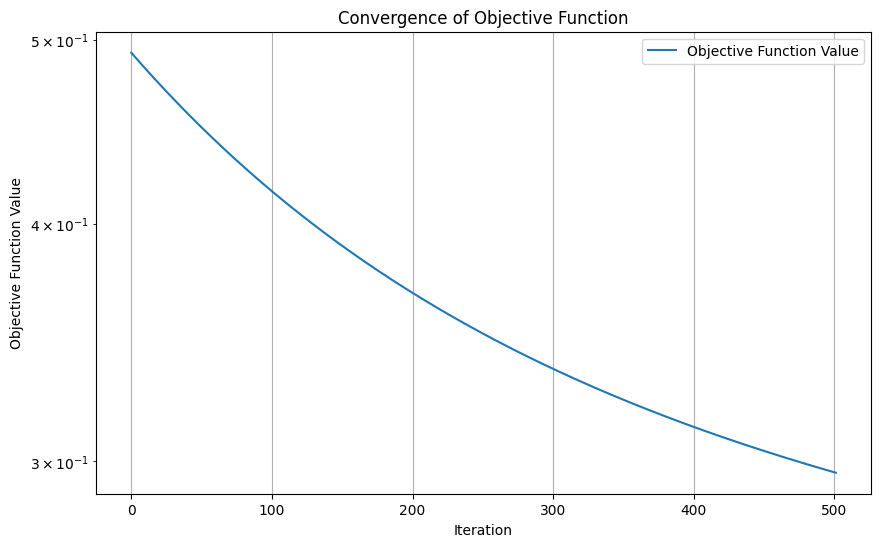

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.semilogy(f_hist, label='Objective Function Value')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergence of Objective Function')
plt.legend()
plt.grid(True)
plt.show()